### Load modules

In [5]:
# Import modules

import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
import pandas as pd
from utils.tools import autoimport
import matplotlib.pyplot as plt
import pickle as pkl
import matplotlib.dates as mdates

In [ ]:
# Import model-related modules

from exp.exp_informer import Exp_Informer
from utils.masking import TriangularCausalMask, ProbMask
from models.encoder import Encoder, EncoderLayer, ConvLayer, EncoderStack
from models.decoder import Decoder, DecoderLayer
from models.attn import FullAttention, ProbAttention, AttentionLayer
from models.embed import DataEmbedding, PositionalEmbedding, TokenEmbedding, FixedEmbedding, TemporalEmbedding, TimeFeatureEmbedding

from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

from utils.tools import StandardScaler
from utils.timefeatures import time_features

from data.data_loader import Dataset_ETT_hour, Dataset_ETT_minute, Dataset_Custom, Dataset_Pred
from exp.exp_basic import Exp_Basic
from models.model import Informer, InformerStack

from utils.tools import EarlyStopping, adjust_learning_rate
from utils.metrics import metric

from utils.postprocessing import ProcessedResult#, ProcessedResultXGB

In [2]:
# Create dataset
df_raw = pd.read_csv('data/processed/SRL/SRL_NEG_00_04.csv')

train =  Dataset_Custom('data/processed/SRL/', freq= 'd', data_path='SRL_NEG_00_04.csv', size = [96, 48, 2], target='capacity_price')
test =  Dataset_Custom('data/processed/SRL/', freq= 'd', data_path='SRL_NEG_00_04.csv', size = [96, 48, 2], target='capacity_price',flag='test')
vali =  Dataset_Custom('data/processed/SRL/', freq= 'd', data_path='SRL_NEG_00_04.csv', size = [96, 48, 2], target='capacity_price', flag='val')

In [39]:
len(df_raw)

len(train)

499

In [6]:
data_loader = DataLoader(
    test,
    batch_size=32,
    shuffle=False,
    num_workers=0,
    drop_last=False)

In [7]:
[(i, len(x[0])) for (i, x) in enumerate(data_loader)]

[(0, 32), (1, 32), (2, 20)]

In [49]:
next(enumerate(data_loader))

(0,
 [tensor([[[-0.2546],
           [-0.2879],
           [-0.2216],
           ...,
           [-0.2414],
           [-0.2414],
           [-0.1441]],
  
          [[-0.2879],
           [-0.2216],
           [-0.2112],
           ...,
           [-0.2414],
           [-0.1441],
           [-0.2075]],
  
          [[-0.2216],
           [-0.2112],
           [ 0.0335],
           ...,
           [-0.1441],
           [-0.2075],
           [-0.1576]],
  
          ...,
  
          [[-0.2516],
           [-0.0479],
           [ 0.1065],
           ...,
           [-0.1395],
           [-0.1752],
           [-0.2040]],
  
          [[-0.0479],
           [ 0.1065],
           [ 0.0725],
           ...,
           [-0.1752],
           [-0.2040],
           [-0.1499]],
  
          [[ 0.1065],
           [ 0.0725],
           [-0.0929],
           ...,
           [-0.2040],
           [-0.1499],
           [-0.1133]]], dtype=torch.float64),
  tensor([[[-0.2214],
           [-0.0954],
  

In [10]:
from scipy.special import softmax
import torch
import pandas as pd
import numpy as np
import math

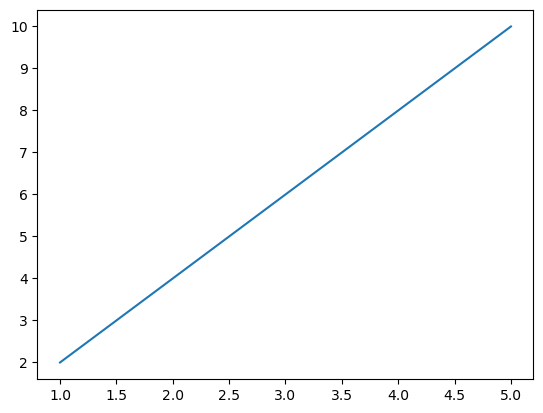

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

x = [1, 2, 3, 4, 5]
y = [2, 4, 6, 8, 10]

fig, ax = plt.subplots()
ax.plot(x, y)

# Display the plot
plt.show()


### Test: `utils.timefeatures.time_features()`

In [52]:
from typing import List

import numpy as np
import pandas as pd
from pandas.tseries import offsets
from pandas.tseries.frequencies import to_offset

def time_features(dates, timeenc=1, freq='h'):
    """
    > `time_features` takes in a `dates` dataframe with a 'dates' column and extracts the date down to `freq` where freq can be any of the following if `timeenc` is 0: 
    > * m - [month]
    > * w - [month]
    > * d - [month, day, weekday]
    > * b - [month, day, weekday]
    > * h - [month, day, weekday, hour]
    > * t - [month, day, weekday, hour, *minute]
    > 
    > If `timeenc` is 1, a similar, but different list of `freq` values are supported (all encoded between [-0.5 and 0.5]): 
    > * Q - [month]
    > * M - [month]
    > * W - [Day of month, week of year]
    > * D - [Day of week, day of month, day of year]
    > * B - [Day of week, day of month, day of year]
    > * H - [Hour of day, day of week, day of month, day of year]
    > * T - [Minute of hour*, hour of day, day of week, day of month, day of year]
    > * S - [Second of minute, minute of hour, hour of day, day of week, day of month, day of year]

    *minute returns a number from 0-3 corresponding to the 15 minute period it falls into.
    """
    if timeenc==0:
        dates['month'] = dates.date.apply(lambda row:row.month,1)
        dates['day'] = dates.date.apply(lambda row:row.day,1)
        dates['weekday'] = dates.date.apply(lambda row:row.weekday(),1)
        dates['hour'] = dates.date.apply(lambda row:row.hour,1)
        dates['minute'] = dates.date.apply(lambda row:row.minute,1)
        dates['minute'] = dates.minute.map(lambda x:x//15)
        freq_map = {
            'y':[],'m':['month'],'w':['month'],'d':['month','day','weekday'],
            'b':['month','day','weekday'],'h':['month','day','weekday','hour'],
            't':['month','day','weekday','hour','minute'],
        }
        return dates[freq_map[freq.lower()]].values
    if timeenc==1:
        dates = pd.to_datetime(dates.date.values)
        return np.vstack([feat(dates) for feat in time_features_from_frequency_str(freq)]).transpose(1,0)

In [53]:
df = pd.read_csv('data/ETT/SRL_NEG_00_04.csv')

In [75]:
df_stamp = df[['date']]
df_stamp['date'] = pd.to_datetime(df_stamp.date)
stamp = time_features(df_stamp, timeenc=0, freq='d')

C:\Users\93cha\AppData\Local\Temp/ipykernel_17640/2697475164.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stamp['date'] = pd.to_datetime(df_stamp.date)


In [81]:
stamp[0:10].shape

(10, 3)

### Test embedding codes

In [76]:
# Create dataset
df_raw = pd.read_csv('data/SRL/SRL_NEG_00_04.csv')

train =  Dataset_Custom('data/SRL/', freq= 'd', data_path='SRL_NEG_00_04.csv', target='capacity_price')
test =  Dataset_Custom('data/SRL/', freq= 'd', data_path='SRL_NEG_00_04.csv', target='capacity_price',flag='test')
vali =  Dataset_Custom('data/SRL/', freq= 'd', data_path='SRL_NEG_00_04.csv', target='capacity_price', flag='val')
# pred =  Dataset_Custom('data/ETT/', freq= 'd', data_path='SRL_NEG_00_04.csv', target='capacity_price', flag='pred')

In [87]:
df_raw = pd.read_csv('data/SRL/SRL_NEG_00_04.csv')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 785 entries, 0 to 784
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                785 non-null    object 
 1   product             785 non-null    object 
 2   capacity_price      785 non-null    float64
 3   offered_capacity    785 non-null    int64  
 4   allocated_capacity  785 non-null    int64  
 5   month               785 non-null    int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 36.9+ KB


In [83]:
df_raw = df_raw[['date']+['capacity_price']] 

In [94]:
val = df_raw[['capacity_price']].values

numpy.ndarray

In [86]:
df_raw[['capacity_price']].values

array([[8.2500e+01],
       [1.5469e+02],
       [3.8900e+02],
       [2.1118e+02],
       [8.7920e+01],
       [5.0480e+01],
       [3.2910e+01],
       [2.5290e+01],
       [2.9000e+01],
       [2.5400e+01],
       [1.9520e+01],
       [1.7080e+01],
       [1.5800e+01],
       [1.4200e+01],
       [8.0000e+01],
       [1.2800e+02],
       [6.2500e+01],
       [3.1360e+01],
       [1.0526e+02],
       [5.2630e+01],
       [2.6000e+01],
       [8.0000e+01],
       [5.4000e+01],
       [3.8250e+01],
       [3.5000e+01],
       [3.4080e+01],
       [2.8280e+01],
       [2.3140e+01],
       [2.4990e+01],
       [2.4380e+01],
       [2.8220e+01],
       [2.3000e+01],
       [2.1100e+01],
       [2.7000e+01],
       [1.9500e+01],
       [1.5070e+01],
       [1.6820e+01],
       [2.0000e+01],
       [2.0000e+01],
       [1.8750e+01],
       [2.3280e+01],
       [2.4000e+01],
       [1.9120e+01],
       [3.1120e+01],
       [2.4990e+01],
       [2.0520e+01],
       [2.4310e+01],
       [1.924

In [81]:
train[0]

(array([[ 1.34026656e-01],
        [ 5.53082448e-01],
        [ 1.91322876e+00],
        [ 8.81001296e-01],
        [ 1.65489219e-01],
        [-5.18462685e-02],
        [-1.53838376e-01],
        [-1.98071721e-01],
        [-1.76535538e-01],
        [-1.97433181e-01],
        [-2.31565998e-01],
        [-2.45729956e-01],
        [-2.53160230e-01],
        [-2.62448071e-01],
        [ 1.19514404e-01],
        [ 3.98149644e-01],
        [ 1.79286396e-02],
        [-1.62835972e-01],
        [ 2.66146199e-01],
        [-3.93657317e-02],
        [-1.93950241e-01],
        [ 1.19514404e-01],
        [-3.14130175e-02],
        [-1.22840206e-01],
        [-1.41706133e-01],
        [-1.47046642e-01],
        [-1.80715067e-01],
        [-2.10552257e-01],
        [-1.99813191e-01],
        [-2.03354180e-01],
        [-1.81063361e-01],
        [-2.11364943e-01],
        [-2.22394255e-01],
        [-1.88145340e-01],
        [-2.31682096e-01],
        [-2.57397807e-01],
        [-2.47239231e-01],
 

In [18]:
train_loader = DataLoader(train, batch_size=2)

In [19]:
sample_loader = next(iter(train_loader))
batch_x, batch_y, batch_x_mark, batch_y_mark = sample_loader

# Input sequence length
batch_x.shape[1]

384

In [29]:
c_in=1
d_model=64

In [35]:
positional_emb = PositionalEmbedding(d_model=d_model)
positional_emb_out = positional_emb(batch_x)

value_emb = TokenEmbedding(c_in=c_in, d_model=d_model)
value_emb_out = value_emb(batch_x.float()) # Convert to float for compatibility

timef_emb = TimeFeatureEmbedding(d_model=d_model, freq='d')
timef_emb_out = timef_emb(batch_x_mark.float())

data_emb = DataEmbedding(c_in=c_in, d_model=d_model, embed_type='timeF', freq='d')
data_emb_out = data_emb(batch_x.float(), batch_x_mark.float())

In [36]:
print('Data input dimension:')
print(batch_x.size())
print('Time feature input dimension:')
print(batch_x_mark.size())
print('Positional embedding outputs:')
print(positional_emb_out.size())
print('Value (token) embedding outputs:')
print(value_emb_out.size())
print('Temporal embedding outputs:')
print(timef_emb_out.size())
print('Data embedding outputs:')
print(data_emb_out.size())

Data input dimension:
torch.Size([2, 384, 1])
Time feature input dimension:
torch.Size([2, 384, 3])
Positional embedding outputs:
torch.Size([1, 384, 64])
Value (token) embedding outputs:
torch.Size([2, 384, 64])
Temporal embedding outputs:
torch.Size([2, 384, 64])
Data embedding outputs:
torch.Size([2, 384, 64])


In [128]:
m = nn.Conv1d(in_channels=1, out_channels=4, kernel_size=3)
m.weight

Parameter containing:
tensor([[[-0.0602,  0.2239,  0.2568]],

        [[ 0.3471,  0.2856, -0.2307]],

        [[ 0.0192,  0.3263,  0.2953]],

        [[-0.3622,  0.3187,  0.4643]]], requires_grad=True)

In [114]:
df_raw = pd.read_csv('data/ETT/ETTh1-mini.csv')

df_stamp = df_raw[['date']]
df_stamp['date'] = pd.to_datetime(df_stamp.date)
data_stamp = time_features(df_stamp, timeenc=0, freq='d')

In [115]:
df_scale = df_raw.iloc[:,1:]
scaler = StandardScaler()
scaler.fit(df_scale.values)

In [116]:
res = scaler.transform(df_scale.values)

In [126]:
[a for a in range(1,3)]

[1, 2]

In [128]:
class TestConv(nn.Module):
    def __init__(self, c_in, c_out):
        super(TestConv, self).__init__()
        self.c_in = c_in
        self.c_out = c_out
        self.conv = nn.Conv1d(in_channels=c_in, out_channels=c_out, kernel_size=3, padding=1,
                              padding_mode='circular')
        
    def forward(self, x):
        x = self.conv(x)
        return x

### Plot prediction & true

In [4]:
pred_seq_raw = np.load('results/20-02-2023_10-52-11/pred.npy')
true_seq_raw = np.load('results/20-02-2023_10-52-11/true.npy')

In [31]:
pd.Series(true_seq_raw.mean(1).squeeze())

0    -0.132360
1    -0.093351
2    -0.133231
3    -0.170731
4    -0.187565
        ...   
73   -0.153316
74   -0.146756
75   -0.184604
76   -0.101536
77   -0.159121
Length: 78, dtype: float32

In [5]:
import matplotlib.pyplot as plt

class ProcessedResult():
    def __init__(self, preds, trues, train_scaler):
        self.scaler = train_scaler
        self.pred_len = preds.shape[0]
        self.pred_raw = self.convert_seq(preds, inverse=False)
        self.true_raw = self.convert_seq(trues, inverse=False)
        self.pred = self.convert_seq(preds, inverse=True)
        self.true = self.convert_seq(trues, inverse=True)
        self.pred_naive = self.true.shift(1)
    
    def convert_seq(self, seq_raw, inverse=True):
        if inverse: 
            seq = self.scaler.inverse_transform(seq_raw)
        else: seq = seq_raw
        
        if seq.shape[1] == 1:
            return pd.Series(seq.mean(1).squeeze())
            
        else:
            array = seq.squeeze()
            array = np.array([np.concatenate([np.repeat(np.nan, i), array[i], np.repeat(np.nan, self.pred_len-i)]) for i in np.arange(self.pred_len)])
            df = pd.DataFrame(array.transpose())
            return df.mean(axis=1)

    def plot_pred_vs_true(self, pred):
        fig = plt.figure(figsize=(12,6))
        plt.plot(self.true, label='True')
        plt.plot(pred, label ='Predict')
        plt.annotate(f'Predicted revenue: {self.predict_revenue(self.pred)}€', 
                     xy=(0.05, 0.9), xycoords='axes fraction',
                     bbox=dict(boxstyle="round,pad=0.3", fc="cyan", ec="b", lw=1))
        plt.legend()
        # for idx in df_rev.index:
        #     plt.vlines(idx, df_rev.loc[idx]['revenue'],0, label ='Revenue', linestyle='--') 
        plt.close()
        return(fig)
    
    def predict_revenue(self, pred):
        return np.nansum(np.where(pred > self.true, 0, pred)).round(2)

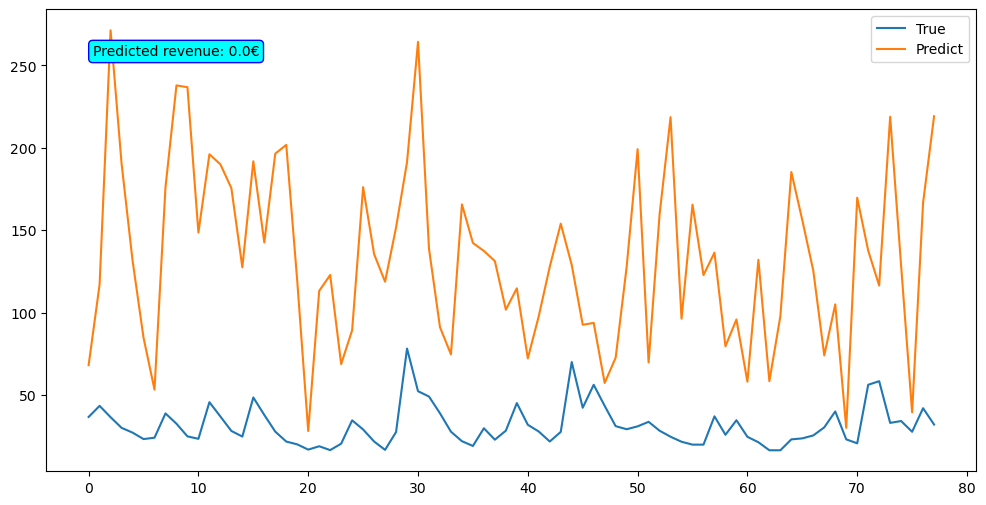

In [6]:
res = ProcessedResult(pred_seq_raw, true_seq_raw, train.scaler)
res.plot_pred_vs_true(pred=res.pred)

In [10]:

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
t = np.arange(0.0, 2.0, 0.01)
s = 1 + np.sin(2 * np.pi * t)

fig, ax = plt.subplots()
ax.plot(t, s)

ax.set(xlabel='time (s)', ylabel='voltage (mV)',
       title='About as simple as it gets, folks')
ax.grid()

plt.show()

<IPython.core.display.Javascript object>

In [36]:
res.true_raw

0    -0.132360
1    -0.093351
2    -0.133231
3    -0.170731
4    -0.187565
        ...   
73   -0.153316
74   -0.146756
75   -0.184604
76   -0.101536
77   -0.159121
Length: 78, dtype: float32

In [14]:
res.true_raw

0    -0.132360
1    -0.093351
2    -0.133231
3    -0.170731
4    -0.187565
        ...   
74   -0.146756
75   -0.184604
76   -0.101536
77   -0.159121
78         NaN
Length: 79, dtype: float64

In [14]:
import matplotlib.pyplot as plt

class Result():
    def __init__(self, data_path, pred_seq_raw, true_seq_raw, root_path='data/ETT'):
        train = Dataset_Custom('data/ETT/', freq= 'd', data_path=data_path, target='capacity_price')
        self.scaler = train.scaler
        self.pred_len = pred_seq_raw.shape[0]
        self.pred_raw = self.convert_seq(pred_seq_raw, inverse=False)
        self.true_raw = self.convert_seq(true_seq_raw, inverse=False)
        self.pred = self.convert_seq(pred_seq_raw, inverse=True)
        self.true = self.convert_seq(true_seq_raw, inverse=True)
        self.pred_naive = self.true.shift(1)
    
    def convert_seq(self, seq_raw, inverse=True):
        if inverse: 
            seq = train.scaler.inverse_transform(seq_raw)
        else: seq = seq_raw
        array = seq.squeeze()
        array = np.array([np.concatenate([np.repeat(np.nan, i), array[i], np.repeat(np.nan, self.pred_len-i)]) for i in np.arange(self.pred_len)])
        df = pd.DataFrame(array.transpose())
        return df.mean(axis=1)

    def plot_pred_vs_true(self, pred, true):
        fig = plt.figure(figsize=(12,6))
        plt.plot(true, label='True')
        plt.plot(pred, label ='Predict')
        plt.legend()
        # for idx in df_rev.index:
        #     plt.vlines(idx, df_rev.loc[idx]['revenue'],0, label ='Revenue', linestyle='--') 
        plt.close()
        return(fig)
    
    def predict_revenue(self, pred):
        return np.nansum(np.where(pred > self.true, 0, pred))

In [5]:
result.pred_naive

NameError: name 'result' is not defined

In [15]:
result = Result(data_path='SRL_NEG_00_04.csv', pred_seq_raw=pred_seq_raw, true_seq_raw=true_seq_raw)

In [16]:
result.predict_revenue(result.pred)

835.8544626743901

In [17]:
result.predict_revenue(result.pred_naive)

595.7600020718476

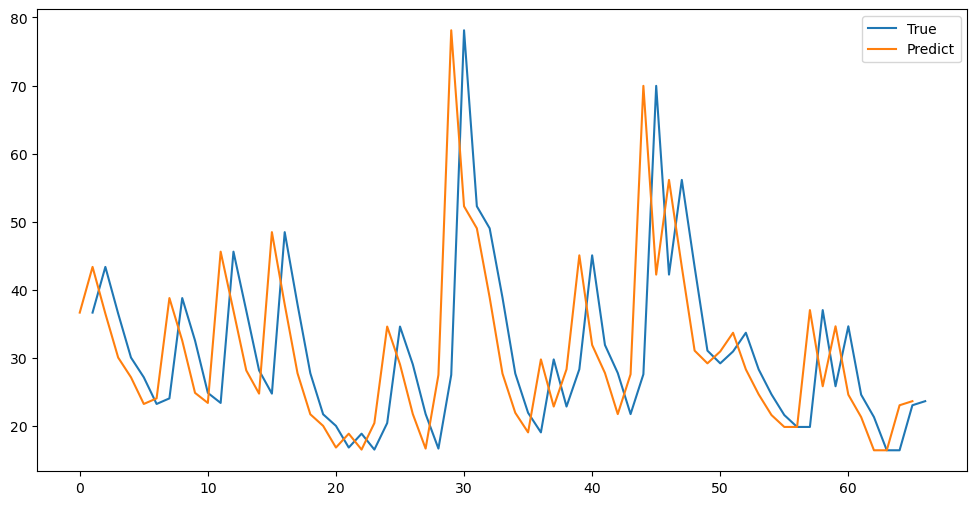

In [18]:
result.plot_pred_vs_true(pred=result.true, true=result.pred_naive)

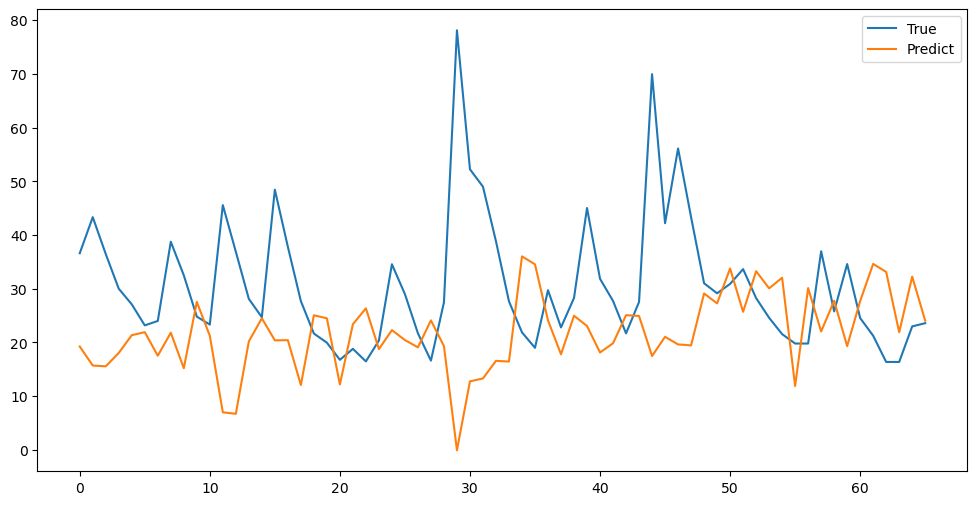

In [19]:
result.plot_pred_vs_true(pred=result.pred, true=result.true)

Preedicted revenue: 1131.1616505880759


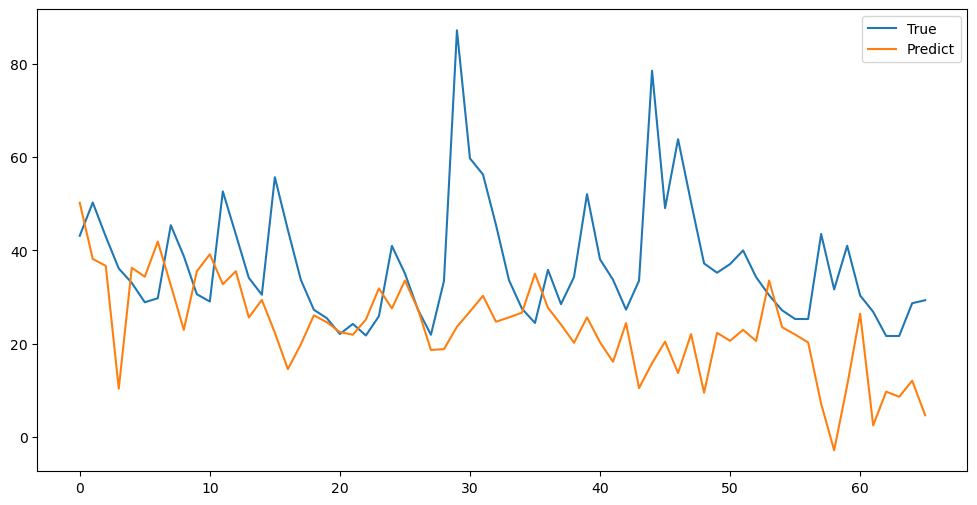

In [72]:
pred_seq_raw = np.load('results/informer_SRL_NEG_00_04_alpha10.0_ftM_sl96_ll48_pl3_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_test_5_25-01-2023_23-53-39/pred.npy')
true_seq_raw = np.load('results/informer_SRL_NEG_00_04_alpha10.0_ftM_sl96_ll48_pl3_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_test_5_25-01-2023_23-53-39/true.npy')

result = Result(data_path='SRL_NEG_00_04.csv', pred_seq_raw=pred_seq_raw, true_seq_raw=true_seq_raw)

print(f'Preedicted revenue: {result.predict_revenue(result.pred)}')

result.plot_pred_vs_true(pred=result.pred, true=result.true)


In [70]:
# Create dataset
df_raw = pd.read_csv('data/ETT/SRL_NEG_00_04.csv')

train =  Dataset_Custom('data/ETT/', freq= 'd', data_path='SRL_NEG_00_04.csv', target='capacity_price')
test =  Dataset_Custom('data/ETT/', freq= 'd', data_path='SRL_NEG_00_04.csv', target='capacity_price',flag='test')
vali =  Dataset_Custom('data/ETT/', freq= 'd', data_path='SRL_NEG_00_04.csv', target='capacity_price', flag='val')

In [71]:
pred_seq = train.scaler.inverse_transform(pred_seq_raw)
true_seq = train.scaler.inverse_transform(true_seq_raw)

In [72]:
true_array = true_seq.squeeze()
pred_len = true_array.shape[0] 
true_array = np.array([np.concatenate([np.repeat(np.nan, i), true_array[i], np.repeat(np.nan, pred_len-i)]) for i in np.arange(pred_len)])

pred_array = pred_seq.squeeze()
pred_array = np.array([np.concatenate([np.repeat(np.nan, i), pred_array[i], np.repeat(np.nan, pred_len-i)]) for i in np.arange(pred_len)])

In [73]:
true_df = pd.DataFrame(true_array.transpose())
true = true_df.mean(axis=1)
pred_df = pd.DataFrame(pred_array.transpose())
pred = pred_df.mean(axis=1)

In [74]:
pred

0      114.921017
1      110.013496
2      106.107333
3       96.984185
4      103.433627
          ...    
147    343.495122
148    358.020845
149    329.128450
150    334.403134
151           NaN
Length: 152, dtype: float64

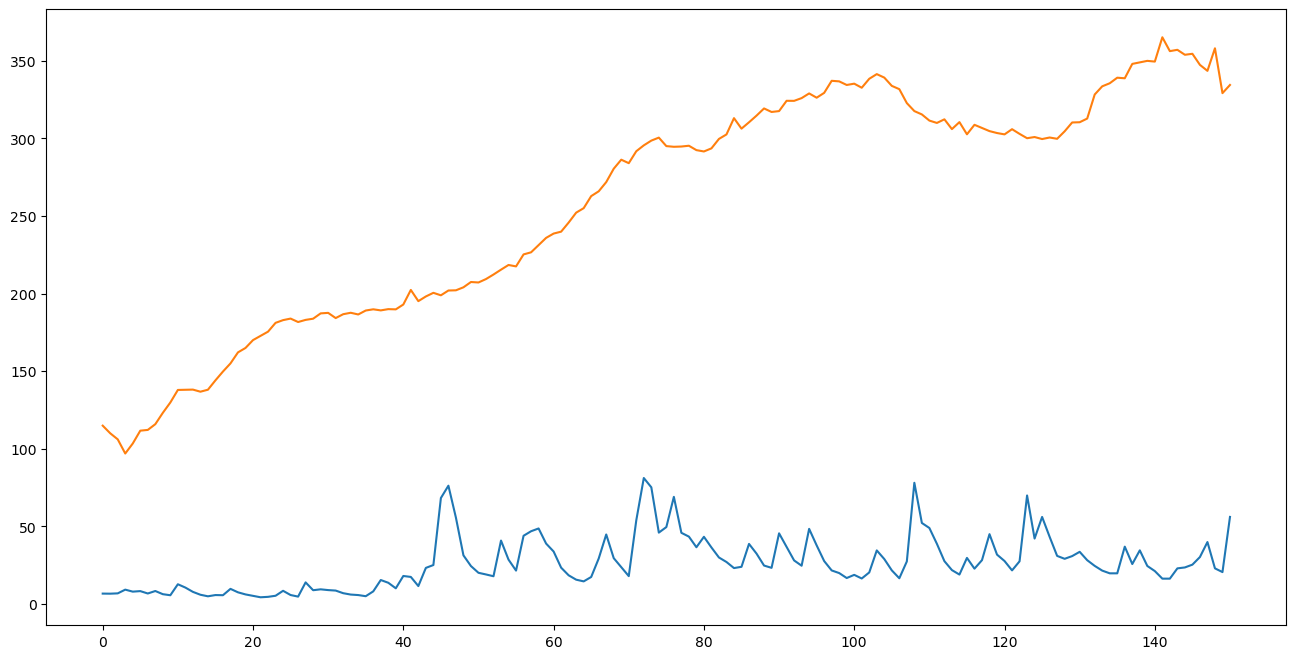

In [76]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.plot(true, label='True')
plt.plot(pred, label='Pred')

### Test custom loss function

In [75]:
true = torch.randn(3, 2, 1)
pred = torch.randn(3, 2, 1)
alpha = 5

In [82]:
diff = pred - true

In [83]:
weighted_diff = torch.where(diff > 0, diff*alpha, diff)

In [87]:
print((weighted_diff**2).mean())

tensor(36.0665)


In [89]:
weighted_diff.mean()

tensor(3.2834)

In [7]:
class WeightedRMSE(nn.Module):
def __init__(self, alpha):
        super(WeightedRMSE, self).__init__()
        self.alpha = alpha
    
    def forward(self, pred, true):
        diff = pred - true
        weighted_diff = torch.where(diff > 0, diff*self.alpha, diff)
        print(weighted_diff)
        return torch.sqrt((weighted_diff**2).mean())

In [4]:
a = torch.Tensor([1, 2, 3])
b = torch.Tensor([2, 1, 3])

In [8]:
loss = WeightedRMSE(alpha=5)
loss(a, b)

tensor([-1.,  5.,  0.])


tensor(2.9439)

In [103]:
loss = nn.MSELoss()
loss(pred, true)

tensor(3.0354)

In [ ]:
def RevenueLoss(pred, true):
    return torch.where(pred > true, 0, pred).sum()*(-1)

In [53]:
class RevenueLoss(nn.Module):
    def __init__(self):
        super(RevenueLoss, self).__init__()
    
    def forward(self, pred, true):
        return torch.where(pred > true, 0, pred).sum()*(-1)

In [54]:
criterion = RevenueLoss()
criterion(pred, true)

tensor(-0.6804)

In [51]:
torch.where(pred > true, 0, pred).sum()*(-1)

tensor(-0.6804)

In [19]:
torch.maximum(diff, torch.zeros(10))

tensor([0.9606, 0.3384, 0.0000, 0.0000, 0.3742, 0.2523, 0.2486, 0.0648, 0.1623,
        0.2631])

In [66]:
from datetime import datetime
now = datetime.now().strftime("%d-%m-%Y_%H:%M:%S")

In [64]:
datetime.now().strftime("%d-%m-%Y_%H:%M:%S")

'25-01-2023_16:39:08'

### Test Tensorboard

In [8]:
informer = Informer(1, 1, 1, 24, 18, 12)

### Test Ray Tune results

In [3]:
from ray import tune, air
from ray.tune import ResultGrid

In [3]:
experiment_path = f"ray_tune/tune_SRL_NEG_00_04_24-02-2023_06-56-42/"
print(f"Loading results from {experiment_path}...")

restored_tuner = tune.Tuner.restore(experiment_path)
result_grid = restored_tuner.get_results()

Loading results from ray_tune/tune_SRL_NEG_00_04_24-02-2023_06-56-42/...


RuntimeError: Could not find Tuner state in restore directory. Did you passthe correct path (including experiment directory?) Got: ray_tune/tune_SRL_NEG_00_04_24-02-2023_06-56-42/

In [72]:
from data.data_loader import Dataset_Custom
import pandas as pd

# Create dataset
df_raw = pd.read_csv('data/processed/SRL/SRL_NEG_00_04.csv')

vali =  Dataset_Custom('data/processed/SRL/', size=[30, 10, 1], freq= 'd', data_path='SRL_NEG_00_04.csv', target='capacity_price', flag='train')

In [2]:
from data.data_loader import Dataset_Custom
vali =  Dataset_Custom('data/processed/SRL/', size=[30, 10, 1], freq= 'd', data_path='SRL_NEG_00_04.csv', target='capacity_price', flag='train', scale='minmax')

In [15]:
num_train = int(len(df_raw)*0.8)
num_test = int(len(df_raw)*0.1)
num_vali = len(df_raw) - num_train - num_test

print(f'Num train: {num_train}')
print(f'Num test: {num_test}')
print(f'Num vali: {num_vali}')

print(f'Idx train: 0:{num_train}')
print(f'Num vali: {num_train}:{num_train + num_vali}')
print(f'Num vali: {num_train + num_vali}:')

Num train: 680
Num test: 85
Num vali: 85
Idx train: 0:680
Num vali: 680:765
Num vali: 765:


In [13]:
df_raw.iloc[len(df_raw) - 1, 0]

'2023-02-28'

In [14]:
num_days

650

### Test plotting TS 

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.dates as mdates

from data.data_loader import Dataset_Custom
import pandas as pd

data = 'HH'
data_type = 'test'

# Create dataset
df_raw = pd.read_csv('data/processed/SRL/SRL_NEG_00_04.csv')

vali =  Dataset_Custom('data/processed/SRL/', size=[30, 10, 1], 
                       freq= 'd', data_path='SRL_NEG_00_04.csv', 
                       target='capacity_price', flag=data_type)

# Generate some sample data
start_date = vali.start_date
end_date = vali.end_date
num_days = len(vali) 
target_data=vali.target_data

# Create a DatetimeIndex with daily frequency
date_index = pd.date_range(start_date, end_date, freq='D')


In [7]:
# Plot the data
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(date_index, target_data)
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
# ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1)

# set the start and end date limits of the x-axis
ax.set_xlim([date_index[0], date_index[-1]])
plt.xticks(rotation=45)

# Set the x-axis label to 'Date'
ax.set_xlabel('Date')

# Set the y-axis label to 'Value'
ax.set_ylabel('Value')

# Set the plot title
ax.set_title(f'{data}, {data_type}, \n from {start_date} to {end_date}')

# Display the plot
plt.show()

ValueError: Image size of 286661x785 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1600x800 with 1 Axes>

In [18]:
pred = np.array([-1, 5, -10, 4, 3])
true = np.array([3, 2, 2, 3, 8])

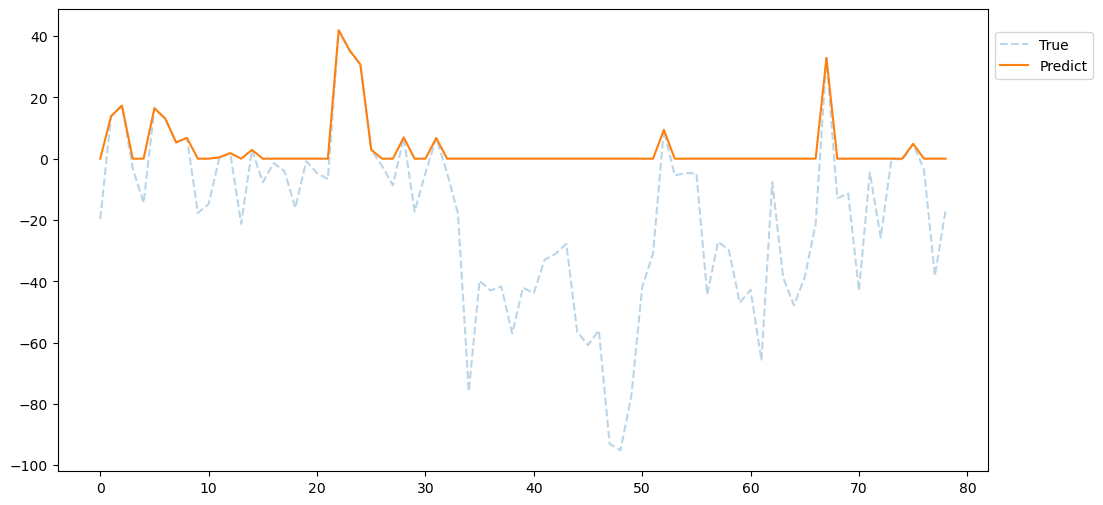

In [37]:
pig, ax = plt.subplots(figsize=(12,6))
ax.plot(pred, label='True', linestyle ='--', alpha = 0.3)
ax.plot(pred_non_neg, label ='Predict')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.9))
# for idx in df_rev.index:
#     plt.vlines(idx, df_rev.loc[idx]['revenue'],0, label ='Revenue', linestyle='--') 

In [24]:
df = pd.read_pickle('data/processed/capacity_anonymousresults_processed.pkl')

## Gather all experiment results info

In [14]:
with open('ray_tune/tune_SRL_POS_20_24_23-04-2023_00-21-33/my_prefix_trainable_bdc1d8f7/processed_result.pickle', 'rb') as f:
    result = pkl.load(f)

In [20]:
import os

In [25]:
lst = os.listdir('ray_tune/tune_SRL_POS_20_24_23-04-2023_00-21-33/')
lst.str.startswith['my_prefix']
[l for l in lst if 'my_prefix' in l][-1]

AttributeError: 'list' object has no attribute 'str'

In [147]:
experiment_type

'xgb_weighted_rmse'

In [115]:
experiment_types = [name for name in os.listdir(f'ray_tune/')]

In [148]:
result_table=pd.DataFrame(columns=['experiment_type',
                                   'product_type',
                                   'model_pred_revenue',
                                   'naive_pred_revenue',
                                   #'pred_len',
                                   'time_stamp'])
# experiment_type='informer_linex_loss'

for experiment_type in experiment_types:

    lst = os.listdir(f'ray_tune/{experiment_type}')
    for product in lst:
        
        if 'xgb' in experiment_type:
            product_type = '_'.join(product.split('_')[3:6])
        else:
            product_type = '_'.join(product.split('_')[2:5])

        trainable_name=[l for l in os.listdir(f'ray_tune/{experiment_type}/{product}') if 'my_prefix' in l][-1]
        
        result_dir = f'ray_tune/{experiment_type}/{product}/{trainable_name}'
        with open(f'{result_dir}/processed_result.pickle', 'rb') as f:
            result = pkl.load(f)
            
        time_stamp='_'.join(lst[0].split('_')[-2:])
        row = [experiment_type, product_type, result.predict_revenue(result.pred), 
            result.predict_revenue(result.pred_naive),
            #result.pred_len, 
            time_stamp]
        
        result_table.loc[len(result_table)] = row
            
    
# print(f'{result.predict_revenue(result.pred_naive)=}')
# print(f'{result.predict_revenue(result.pred)=}')
# print(f'{result.pred_len=}')

## Revamp the ProcessedResult plotting

In [94]:
with open('processed_result_test.pkl', 'rb') as f:
    result = pkl.load(f)
    
self = result

# self.add_line_breaks_to_args_string = add_line_breaks_to_args_string

pred = self.pred

In [95]:
def add_line_breaks_to_args_string(args, max_len=80):
    """ Break long string of args Namespaces with line breaks
    for plotting results.

    Args:
        args (str): args list pron args_parser
        max_len (int): max length before adding line break
    """
    
    max_len = 80
    rows = ['']

    # Convert to string
    args = str(self.args)

    # Filter content within brackets
    args = args[args.find("(")+1:args.find(")")].split(',')

    # Add args to a row until max_len reached, then create new row
    for arg in args:
        if len(rows[-1]) < max_len:
            rows[-1] = rows[-1] + (arg) + ',' 
        else:
            rows.append('')
            rows[-1] = rows[-1] + (arg) + ',' 
    
    return '\n'.join(rows)

Text(0.5, 1.0, 'Product SRL_NEG_00_04, 2022-02-04 to 2022-11-05 (Validation Set)')

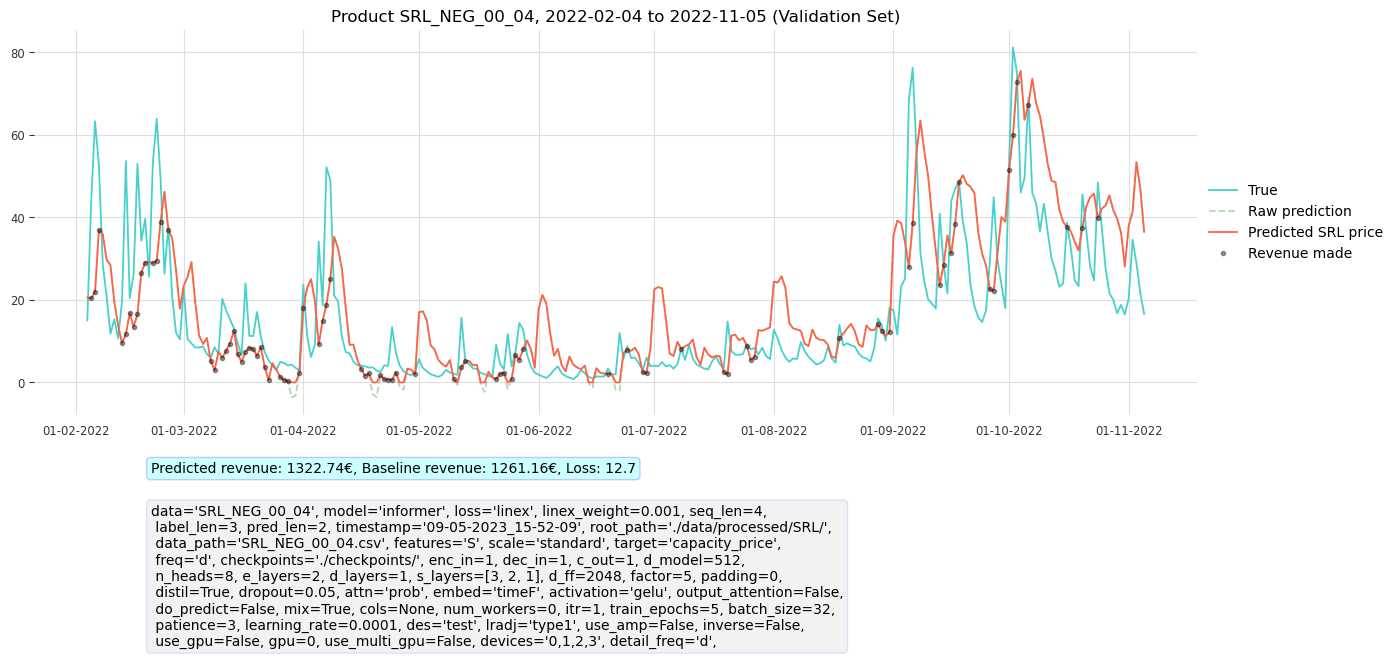

In [131]:
# Build plotting pred true func

fig, ax = plt.subplots(figsize=(15,5))
pred_non_neg = np.where(pred < 0, 0, pred)


ax.plot(self.data.target_date_range, self.true, label='True', color='mediumturquoise')
ax.plot(self.data.target_date_range, pred, label ='Raw prediction', linestyle ='--', alpha = 0.3, color='green')
ax.plot(self.data.target_date_range, pred_non_neg, label ='Predicted SRL price', color='tomato')

# Plot where revenues are made
range = self.data.target_date_range.reset_index(drop=True)
diff = pred - self.true
query = (diff < 0) & (pred > 0) # Positive predictions which are lower than trues
ax.plot(range[query], pred_non_neg[query], '.', alpha=0.4, color='black', label ='Revenue made')

# plt.annotate(f'Predicted revenue: {self.predict_revenue(pred)}€', 
#              xy=(0.05, 0.9), xycoords='axes fraction',
#              bbox=dict(boxstyle="round,pad=0.3", fc="cyan", ec="b", lw=1, alpha=0.5))
# plt.annotate(f'Weighted RMSE (alpha={self.args.alpha}): {self.weighted_rmse(pred)}', 
#              xy=(0.05, 0.8), xycoords='axes fraction',
#              bbox=dict(boxstyle="round,pad=0.3", fc="cyan", ec="b", lw=1, alpha=0.5))

plt.annotate(f'Predicted revenue: {self.predict_revenue(pred)}€, Baseline revenue: {self.predict_revenue(self.pred_naive)}€, Loss: {self.loss(pred)}', 
                xy=(0.1, -0.15), xycoords='axes fraction',
                bbox=dict(boxstyle="round,pad=0.3", fc="cyan", ec="b", lw=1, alpha=0.2))


args_dict = self.args.__dict__

loss_weights = ['linex_weight', 'w_rmse_weight']

if f'{self.args.loss}_weight' in loss_weights:
    for loss_weight in loss_weights:
        if loss_weight != f'{self.args.loss}_weight' and 'w_rmse_weight' in args_dict.keys():
            del args_dict[loss_weight]

args = add_line_breaks_to_args_string(args_dict, max_len=80)

plt.annotate(args, 
                xy=(0.1, -0.6), xycoords='axes fraction',
                bbox=dict(boxstyle="round,pad=0.3", fc="gray", ec="b", lw=1, alpha=0.1))

ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Title
ax.set_title(f'Product {self.args.data}, {self.data.target_date_range.iloc[0]._date_repr} to {self.data.target_date_range.iloc[-1]._date_repr} (Validation Set)') # Get string representation

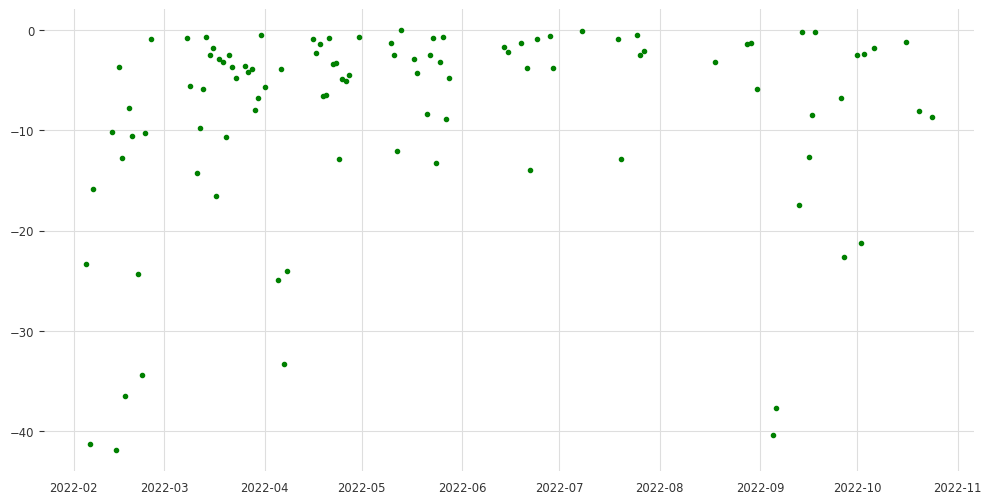

In [91]:
fig, ax = plt.subplots(figsize=(12,6))
pred_non_neg = np.where(pred < 0, 0, pred)

ax.plot(self.data.target_date_range, self.true, label='True', color='blue')
ax.plot(self.data.target_date_range, pred, label ='Raw prediction', linestyle ='--', alpha = 0.3, color='green')
ax.plot(self.data.target_date_range, pred_non_neg, label ='Predicted SRL price', color='red')

ax.plot(range[diff < 0], diff[diff < 0], '.g')

In [38]:
args_dict = self.args.__dict__

loss_weights = ['linex_weight', 'w_rmse_weight']

if f'{self.args.loss}_weight' in loss_weights:
    for loss_weight in loss_weights:
        if loss_weight != f'{self.args.loss}_weight':
            print(loss_weight)
            del args_dict[loss_weight]

In [44]:
args_dict

{'data': 'SRL_NEG_00_04',
 'model': 'informer',
 'loss': 'linex',
 'seq_len': 4,
 'label_len': 3,
 'pred_len': 2,
 'timestamp': '09-05-2023_15-34-10',
 'root_path': './data/processed/SRL/',
 'data_path': 'SRL_NEG_00_04.csv',
 'features': 'S',
 'scale': 'standard',
 'target': 'capacity_price',
 'freq': 'd',
 'checkpoints': './checkpoints/',
 'linex_weight': 0.001,
 'enc_in': 1,
 'dec_in': 1,
 'c_out': 1,
 'd_model': 512,
 'n_heads': 8,
 'e_layers': 2,
 'd_layers': 1,
 's_layers': [3, 2, 1],
 'd_ff': 2048,
 'factor': 5,
 'padding': 0,
 'distil': True,
 'dropout': 0.05,
 'attn': 'prob',
 'embed': 'timeF',
 'activation': 'gelu',
 'output_attention': False,
 'do_predict': False,
 'mix': True,
 'cols': None,
 'num_workers': 0,
 'itr': 1,
 'train_epochs': 5,
 'batch_size': 32,
 'patience': 3,
 'learning_rate': 0.0001,
 'des': 'test',
 'lradj': 'type1',
 'use_amp': False,
 'inverse': False,
 'use_gpu': False,
 'gpu': 0,
 'use_multi_gpu': False,
 'devices': '0,1,2,3',
 'detail_freq': 'd'}

In [16]:
main_args = ['data', 'model', 'loss', 'seq_len', 'label_len', 'pred_len']

## Test plotting loss functions of Informer

In [4]:
from utils.metrics import LinEx, LinLin, weighted_RMSE
import numpy as np
import matplotlib.pyplot as plt

In [10]:
linlin_weight = 0.8
pred = np.arange(-4, 4, step=0.1)
true = np.zeros_like(pred)

In [33]:
# This loss function aims to provide a forecast with an α 
# probability of under forecasting the demand and an (α-1) 
# probability of over forecasting the demand.

linlin_weight = 0.8
diff = true - pred # positive = underestimation, negative = overestimation
linlin_loss = np.where(diff > 0, diff*linlin_weight, -diff*(1-linlin_weight))

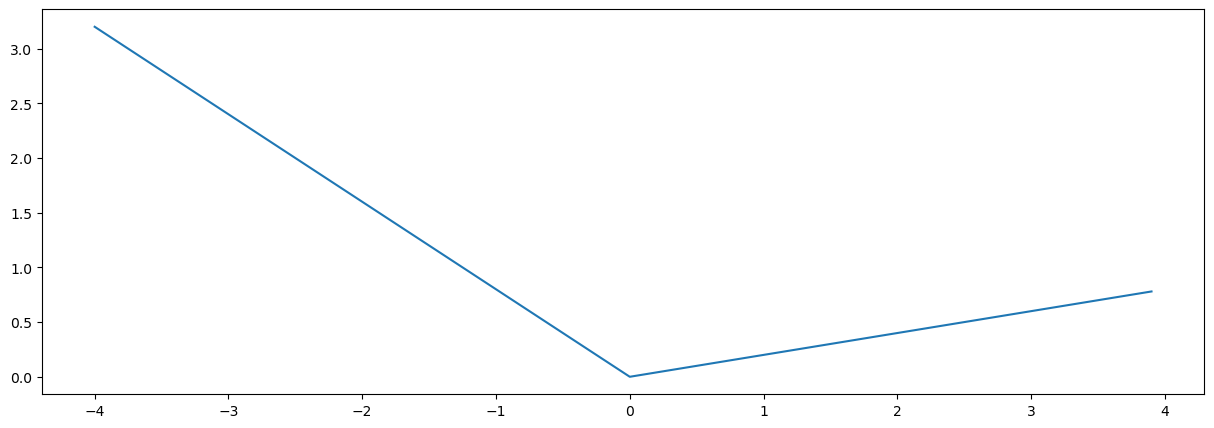

In [34]:
fig, ax = plt.subplots(figsize=(15,5))

ax.plot(pred, linlin_loss)

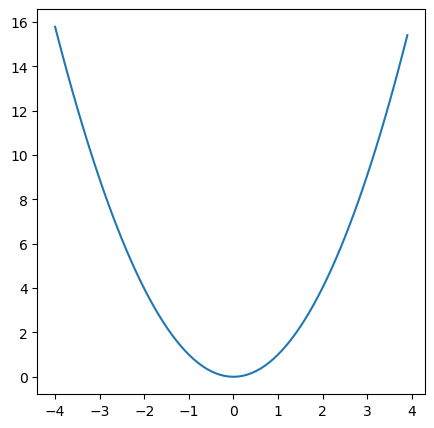

In [48]:
linex_weight= 0.01

diff = pred - true # this order matters
linex_loss = (2/np.power(linex_weight, 2))*(np.exp(linex_weight*diff)- linex_weight*diff - 1)

fig, ax = plt.subplots(figsize=(5,5))

ax.plot(pred, linex_loss)

In [1]:
from utils.tools import autoimport

c:\Users\cle\AppData\Local\miniforge3\envs\test\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [103]:
autoimport('data.external_data_conversion')
from data.external_data_conversion import convert_external_data_finanzen, add_external_data_to_srl

In [94]:
convert_external_data_finanzen('gas')
convert_external_data_finanzen('coal')

d:\srl_informer\data\external_data_conversion.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  # 'Tageshoch': [np.NaN],


Processed data saved!


d:\srl_informer\data\external_data_conversion.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  # 'Tageshoch': [np.NaN],


Processed data saved!


In [85]:
data_name='coal'
path = os.path.join('data', 'raw', 'external_data', f'{data_name}.xlsx')

df = pd.read_excel(path, 
                    dtype={'Datum': 'object', 
                            # 'Schluss': 'float',
                            # 'Eröffnung': 'float',
                            # 'Tageshoch': 'float',
                            # 'Tagestief': 'float',
                            })

df['Schluss'] = df['Schluss'].str.replace(',','.').astype('float64')

In [83]:
df.Schluss.str.replace(',','.')

0      122.45
1      125.00
2      127.15
3      127.15
4      125.30
        ...  
620     50.80
621     51.40
622     50.85
623     51.05
624     50.90
Name: Schluss, Length: 625, dtype: object

## Function preprocess: add xternal data to SRL data

In [12]:
import pandas as pd

In [44]:
import os

In [61]:
def add_external_data_to_srl(srl_product_name = 'SRL_NEG_00_04', 
                             external_data_names = ['gas']):
    
    assert type(external_data_names) in [str, list]
    
    if type(external_data_names) == str:
        external_data_names = [external_data_names]
        
    root_path= os.path.join('data', 'processed')

    df = pd.read_csv(os.path.join(root_path, 'SRL', f'{srl_product_name}.csv'))
    
    for name in external_data_names:
        ex = pd.read_csv(os.path.join(root_path, 'external_data', f'{name}.csv'))
        df = df.merge(ex, on='date')
        
    try:
        assert not df.isna().any().all()
    
    except AssertionError as e:
        print('NA values in merged dataset')
        
    return df

In [105]:
convert_external_data_finanzen('gas')
convert_external_data_finanzen('coal')

# add_external_data_to_srl(external_data_names=['gas','coal'])

d:\srl_informer\data\external_data_conversion.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  # 'Tageshoch': [np.NaN],


Processed data saved!


d:\srl_informer\data\external_data_conversion.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  # 'Tageshoch': [np.NaN],


Processed data saved!


In [97]:
os.path('data/processed/SRL/')

TypeError: 'module' object is not callable

In [110]:
p = os.path.normpath('data/processed/SRL/SRL_NEG_00_04.csv')

import pandas as pd

pd.read_csv(p)

,date,product,capacity_price,offered_capacity,allocated_capacity,month
0,2020-11-01,NEG_00_04,82.50,30,30,11
1,2020-11-02,NEG_00_04,154.69,30,30,11
2,2020-11-03,NEG_00_04,389.00,80,80,11
3,2020-11-04,NEG_00_04,211.18,80,80,11
4,2020-11-05,NEG_00_04,87.92,30,30,11
...,...,...,...,...,...,...
913,2023-05-03,NEG_00_04,2.19,20,20,5
914,2023-05-04,NEG_00_04,1.88,20,20,5
915,2023-05-05,NEG_00_04,2.09,20,20,5
916,2023-05-06,NEG_00_04,1.83,20,20,5


In [111]:
products=[
    'SRL_NEG_00_04',
    # 'SRL_NEG_00_04',
    # 'SRL_NEG_04_08',
    # 'SRL_NEG_08_12',
    # 'SRL_NEG_12_16',
    # 'SRL_NEG_16_20',
    # 'SRL_NEG_20_24',
    # 'SRL_POS_00_04',
    # 'SRL_POS_04_08',
    # 'SRL_POS_08_12',
    # 'SRL_POS_12_16',
    # 'SRL_POS_16_20',
    # 'SRL_POS_20_24',
]

for product in products:
    add_external_data_to_srl(srl_product_name=product,
                             external_data_names=['gas','coal'])    
    print('External data added!')

External data added!
